In [6]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from keras.applications.xception import preprocess_input as xception_preprocess

import pickle

# Desactiva todas las GPUs
tf.config.set_visible_devices([], 'GPU')

## Evaluación binaria con conjunto de test

In [10]:
def test_model(model_path, preprocess_fn, test_dir="data/processed/test", image_size=(224, 224)):
    # Cargar dataset desde carpeta test
    test_ds = keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=image_size,   # ajusta al tamaño que tu modelo espera
        batch_size=32,
        shuffle=False            # importante para que las etiquetas correspondan
    )

    # Clases detectadas
    class_names = test_ds.class_names
    print("Clases detectadas:", class_names)

    # Mapear dataset con la función de preprocesamiento
    test_ds = test_ds.map(lambda x, y: (preprocess_fn(x), y))

    # Cargar modelo entrenado
    if isinstance(model_path, str):
        model = keras.models.load_model(model_path)
    else:
        model = model_path

    # Predicciones
    y_pred_probs = model.predict(test_ds)

    # Si tu modelo tiene salida softmax (2 neuronas o más)
    if y_pred_probs.shape[1] > 1:
        y_pred = np.argmax(y_pred_probs, axis=1)
    else:  # salida sigmoid (1 neurona)
        y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

    # Etiquetas verdaderas
    y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

    # Reporte de clasificación
    report = classification_report(y_true, y_pred, target_names=class_names)

    return report


### Modelo entrenado desde 0

In [11]:
print(test_model("models/classifier/new_model_11_20_h12_29.keras", lambda x: x/255.))

Found 1002 files belonging to 2 classes.


Clases detectadas: ['benignas', 'malignas']
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step
              precision    recall  f1-score   support

    benignas       0.84      0.91      0.87       807
    malignas       0.43      0.27      0.33       195

    accuracy                           0.79      1002
   macro avg       0.63      0.59      0.60      1002
weighted avg       0.76      0.79      0.77      1002



### Modelo partiendo de VGG (imagenet)

In [ ]:
print(test_model("models/classifier/vgg16_finetuned_11_25_11_17.keras", vgg16_preprocess))

Found 1002 files belonging to 2 classes.
Clases detectadas: ['benignas', 'malignas']
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
              precision    recall  f1-score   support

    benignas       0.94      0.89      0.92       807
    malignas       0.63      0.75      0.69       195

    accuracy                           0.87      1002
   macro avg       0.78      0.82      0.80      1002
weighted avg       0.88      0.87      0.87      1002



2025-11-29 12:27:44.115826: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Modelo partiendo de ResNet50 (imagenet)

In [ ]:
print(test_model("models/classifier/resnet50_finetuned_11_26_12_13.keras", resnet_preprocess))

Found 1002 files belonging to 2 classes.
Clases detectadas: ['benignas', 'malignas']
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 726ms/step
              precision    recall  f1-score   support

    benignas       0.96      0.81      0.88       807
    malignas       0.52      0.85      0.64       195

    accuracy                           0.82      1002
   macro avg       0.74      0.83      0.76      1002
weighted avg       0.87      0.82      0.83      1002



### Modelo partiendo de Xception (imagenet)

In [ ]:
print(test_model("models/classifier/inceptionv3_finetuned_11_26_13_17.keras", xception_preprocess))

Found 1002 files belonging to 2 classes.
Clases detectadas: ['benignas', 'malignas']
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step
              precision    recall  f1-score   support

    benignas       0.90      0.81      0.85       807
    malignas       0.44      0.61      0.51       195

    accuracy                           0.77      1002
   macro avg       0.67      0.71      0.68      1002
weighted avg       0.81      0.77      0.79      1002



2025-11-29 12:28:37.274809: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Evaluación Malignas con test

In [4]:
EMBED_DIM=128
IMG_SIZE=(128,128)
def contrastive_encoder(input_shape=(IMG_SIZE[0],IMG_SIZE[1],3), embedding_dim=EMBED_DIM):
    inputs = keras.layers.Input(shape=input_shape)

    # Bloque 1
    x = keras.layers.Conv2D(64, 3, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    s = keras.layers.Conv2D(64, 1, padding='same', use_bias=False)(inputs)
    s = keras.layers.BatchNormalization()(s)
    x = keras.layers.Add()([x, s])
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D()(x)

    # Bloque 2
    y = keras.layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.ReLU()(y)
    y = keras.layers.Conv2D(128, 3, padding='same', use_bias=False)(y)
    y = keras.layers.BatchNormalization()(y)
    s2 = keras.layers.Conv2D(128, 1, padding='same', use_bias=False)(x)
    s2 = keras.layers.BatchNormalization()(s2)
    y = keras.layers.Add()([y, s2])
    y = keras.layers.ReLU()(y)
    y = keras.layers.MaxPooling2D()(y)

    # Bloque 3
    z = keras.layers.Conv2D(256, 3, padding='same', use_bias=False)(y)
    z = keras.layers.BatchNormalization()(z)
    z = keras.layers.ReLU()(z)
    z = keras.layers.Conv2D(256, 3, padding='same', use_bias=False)(z)
    z = keras.layers.BatchNormalization()(z)
    s3 = keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(y)
    s3 = keras.layers.BatchNormalization()(s3)
    z = keras.layers.Add()([z, s3])
    z = keras.layers.ReLU()(z)

    z = keras.layers.GlobalAveragePooling2D()(z)
    z = keras.layers.Dense(512, activation='relu')(z)
    z = keras.layers.BatchNormalization()(z)

    # Proyección (cabeza contrastiva)timestamps
    p = keras.layers.Dense(embedding_dim, activation='relu')(z)
    p = keras.layers.Dense(embedding_dim)(p)
    outputs = keras.layers.Lambda(
    lambda t: tf.math.l2_normalize(t, axis=1),
    name="proj_norm",
    output_shape=(embedding_dim,))(p)


    return keras.models.Model(inputs, outputs, name="ContrastiveEncoder")

def classifier(input_shape=(IMG_SIZE[0],IMG_SIZE[1],3), embedding_dim=EMBED_DIM, num_classes=3):
    e = contrastive_encoder(input_shape, embedding_dim)
    x = e.output
    clf = keras.layers.Dense(num_classes, activation="softmax")(x)
    return keras.models.Model(e.input, clf)

def test_knn(model_path, encoder_path, preprocess_fn, test_dir="data/malignas_classes/test"):
    # Cargar dataset desde carpeta test
    test_ds = keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(128, 128),   # ajusta al tamaño que tu encoder espera
        batch_size=32,
        shuffle=False
    )

    # Clases detectadas
    class_names = test_ds.class_names
    print("Clases detectadas:", class_names)

    # Mapear dataset con la función de preprocesamiento
    test_ds = test_ds.map(lambda x, y: (preprocess_fn(x), y))

    # Cargar el modelo KNN entrenado
    with open(model_path, "rb") as f:
        knn_loaded = pickle.load(f)
    # Cargar encoder
    encoder = contrastive_encoder(
    input_shape=(128,128, 3),
    embedding_dim=128
    )

    encoder.load_weights(encoder_path)

    # Extraer embeddings con el encoder
    embeddings = []
    labels = []
    for batch_x, batch_y in test_ds:
        emb = encoder.predict(batch_x)   # generar embeddings
        embeddings.append(emb)
        labels.append(batch_y.numpy())

    X_test = np.concatenate(embeddings, axis=0)
    y_true = np.concatenate(labels, axis=0)

    # Predicciones con el KNN cargado
    y_pred = knn_loaded.predict(X_test)

    # Reporte de clasificación
    report = classification_report(y_true, y_pred, target_names=class_names)
    return report


### KNN con SupConLoss

In [ ]:
# Cargar el modelo entrenado desde el archivo
print(test_knn("models/malignClassifier/knn_model_11_29_h11_36.pkl","models/encoder/encoder_11_26_h14_27.keras",lambda x: x/255.))


Found 195 files belonging to 3 classes.


Clases detectadas: ['akiec', 'bcc', 'mel']


/home/miguel/python3.12/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
              precision    recall  f1-score   support

       akiec       0.37      0.35      0.36        31
         bcc       0.64      0.43      0.52        53
         mel       0.79      0.92      0.85       111

    accuracy                           0.70       195
   macro avg       0.60      0.57      0.58       195
weighted avg       0.68      0.70      0.68       195



In [ ]:
print(test_knn("models/malignClassifier/knn_model_finetunedEncoder_11_29_h11_35.pkl","models/encoder/encoder_finetuned_11_26_h15_34.keras",lambda x: x/255.))

Found 195 files belonging to 3 classes.
Clases detectadas: ['akiec', 'bcc', 'mel']


/home/miguel/python3.12/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
              precision    recall  f1-score   support

       akiec       0.83      0.32      0.47        31
         bcc       0.84      0.77      0.80        53
         mel       0.81      0.98      0.89       111

    accuracy                           0.82       195
   macro avg       0.83      0.69      0.72       195
weighted avg       0.82      0.82      0.80       195



In [ ]:
print(test_knn("models/malignClassifier/knn_model_11_29_h11_36.pkl","models/encoder/encoder_finetuned_11_26_h15_34.keras",lambda x: x/255.))

Found 195 files belonging to 3 classes.
Clases detectadas: ['akiec', 'bcc', 'mel']


/home/miguel/python3.12/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
              precision    recall  f1-score   support

       akiec       0.53      0.32      0.40        31
         bcc       0.82      0.70      0.76        53
         mel       0.83      0.98      0.90       111

    accuracy                           0.80       195
   macro avg       0.73      0.67      0.69       195
weighted avg       0.78      0.80      0.78       195



### Modelo clásico

In [ ]:
m = classifier(
    input_shape=(128,128, 3),
    embedding_dim=128, 
    num_classes=3
    )

m.load_weights("models/malignClassifier/classifier_11_26_h15_34.keras")
print(test_model(m, lambda x: x/255, "data/malignas_classes/test", image_size=(128,128)))

Found 195 files belonging to 3 classes.
Clases detectadas: ['akiec', 'bcc', 'mel']
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 521ms/step
              precision    recall  f1-score   support

       akiec       0.60      0.39      0.47        31
         bcc       0.83      0.72      0.77        53
         mel       0.84      0.97      0.90       111

    accuracy                           0.81       195
   macro avg       0.75      0.69      0.71       195
weighted avg       0.80      0.81      0.80       195



## Evaluación de pipeline completo

In [ ]:
def load_binary_model(model_path, preprocess_fn, image_size=(224,224)):
    model = keras.models.load_model(model_path)
    return model, preprocess_fn, image_size

def load_knn_pipeline(knn_path, encoder_path, preprocess_fn, image_size=(128,128)):
    # Cargar KNN
    with open(knn_path, "rb") as f:
        knn_loaded = pickle.load(f)
    # Cargar encoder
    encoder = contrastive_encoder(
        input_shape=(image_size[0], image_size[1], 3),
        embedding_dim=128
    )
    encoder.load_weights(encoder_path)
    return knn_loaded, encoder, preprocess_fn, image_size

def test_pipeline(binary_model_path, binary_preprocess, knn_path, encoder_path, knn_preprocess,
                  test_dir="data/full/test"):
    # Dataset completo con todas las clases (para binario)
    test_ds = keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(224,224),   # tamaño para el binario
        batch_size=32,
        shuffle=False
    )
    class_names = test_ds.class_names
    print("Clases detectadas:", class_names)

    # Mapear dataset con preprocesamiento binario
    test_ds_bin = test_ds.map(lambda x, y: (binary_preprocess(x), y))

    # Cargar modelos
    binary_model = keras.models.load_model(binary_model_path)
    encoder = contrastive_encoder(input_shape=(128,128,3), embedding_dim=128)
    encoder.load_weights(encoder_path)
    with open(knn_path, "rb") as f:
        knn = pickle.load(f)

    # Predicciones binario
    y_pred_probs = binary_model.predict(test_ds_bin)
    if y_pred_probs.shape[1] > 1:
        y_pred_bin = np.argmax(y_pred_probs, axis=1)
    else:
        y_pred_bin = (y_pred_probs > 0.5).astype("int32").flatten()

    # Etiquetas verdaderas
    y_true = np.concatenate([y.numpy() for _, y in test_ds_bin], axis=0)

    # Indices de malignas
    malign_indices = np.where(y_pred_bin == 1)[0]

    # --- SOLO malignas ---
    file_paths = np.array(test_ds.file_paths)[malign_indices]

    # Crear dataset solo con imágenes malignas
    malign_ds = tf.data.Dataset.from_tensor_slices(file_paths)
    malign_ds = malign_ds.map(
        lambda path: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(path)), (128,128)), 0)
    )
    malign_ds = malign_ds.map(lambda x,y: (knn_preprocess(x), y)).batch(32)

    # Embeddings solo de malignas
    X_test = encoder.predict(malign_ds.map(lambda x,y: x), verbose=1)
    y_pred_knn = knn.predict(X_test)

    # Mapeo de índices KNN a nombres de clase (orden alfabético)
    knn_classes = ["akiec","bcc","mel"]
    y_pred_knn_labels = [knn_classes[idx] for idx in y_pred_knn]

    # Fusionar resultados:
    final_pred = []
    malign_counter = 0
    for i in range(len(y_true)):
        if y_pred_bin[i] == 0:
            final_pred.append(class_names.index("benignas"))
        else:
            knn_label = y_pred_knn_labels[malign_counter]
            final_pred.append(class_names.index(knn_label))
            malign_counter += 1

    # Reporte final
    report = classification_report(y_true, final_pred, target_names=class_names)#, zero_division=0)
    return report



In [ ]:
print(test_model("models/full/full_model_11_29_h16_08.keras",lambda x: x/255,"data/full/test"))

Found 1002 files belonging to 4 classes.


Clases detectadas: ['akiec', 'bcc', 'benignas', 'mel']
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step
              precision    recall  f1-score   support

       akiec       0.24      0.30      0.27        33
         bcc       0.19      0.45      0.26        51
    benignas       0.91      0.62      0.74       807
         mel       0.24      0.62      0.35       111

    accuracy                           0.60      1002
   macro avg       0.39      0.50      0.41      1002
weighted avg       0.78      0.60      0.66      1002



2025-11-29 17:34:44.670919: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
print(test_pipeline("models/classifier/vgg16_finetuned_11_25_11_17.keras",vgg16_preprocess,
              "models/malignClassifier/knn_model_finetunedEncoder_11_29_h11_35.pkl",
              "models/encoder/encoder_finetuned_11_26_h15_34.keras",lambda x: x/255))

Found 1002 files belonging to 4 classes.


Clases detectadas: ['akiec', 'bcc', 'benignas', 'mel']


/home/miguel/python3.12/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 488ms/step
              precision    recall  f1-score   support

       akiec       0.48      0.30      0.37        33
         bcc       0.56      0.49      0.52        51
    benignas       0.91      0.78      0.84       807
         mel       0.30      0.66      0.41       111

    accuracy                           0.74      1002
   macro avg       0.56      0.56      0.54      1002
weighted avg       0.81      0.74      0.76      1002



In [ ]:
print(test_model("models/full/vgg16Full_finetuned_11_29_17_11.keras",vgg16_preprocess,"data/full/test"))

Found 1002 files belonging to 4 classes.
Clases detectadas: ['akiec', 'bcc', 'benignas', 'mel']


2025-12-01 17:57:07.860520: I external/local_xla/xla/service/service.cc:163] XLA service 0x70128c00bfd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-12-01 17:57:07.860544: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-12-01 17:57:07.908042: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764608228.126748    9119 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
              precision    recall  f1-score   support

       akiec       0.31      0.67      0.43        33
         bcc       0.39      0.65      0.49        51
    benignas       0.94      0.69      0.79       807
         mel       0.28      0.65      0.39       111

    accuracy                           0.68      1002
   macro avg       0.48      0.66      0.52      1002
weighted avg       0.82      0.68      0.72      1002



2025-12-01 17:58:01.138949: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Matrices de confusión

In [11]:
# --- Función auxiliar para dataset ---
def get_test_dataset(test_dir, image_size, preprocess_fn):
    test_ds = keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=image_size,
        batch_size=32,
        shuffle=False
    )
    class_names = test_ds.class_names
    test_ds = test_ds.map(lambda x, y: (preprocess_fn(x), y))
    y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
    return test_ds, y_true, class_names

# --- Predicción con modelo binario clásico ---
def predict_binary_model(model_path, preprocess_fn, test_dir, image_size):
    test_ds, y_true, class_names = get_test_dataset(test_dir, image_size, preprocess_fn)
    model = keras.models.load_model(model_path)
    y_pred_probs = model.predict(test_ds)
    if y_pred_probs.shape[1] > 1:
        y_pred = np.argmax(y_pred_probs, axis=1)
    else:
        y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
    return y_true, y_pred, class_names

# --- Predicción con pipeline binario + KNN ---
def predict_knn_pipeline(binary_model_path, binary_preprocess, knn_path, encoder_path, knn_preprocess,
                         test_dir, image_size_bin=(224,224), image_size_knn=(128,128)):
    # Dataset completo
    test_ds = keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=image_size_bin,
        batch_size=32,
        shuffle=False
    )
    class_names = test_ds.class_names
    test_ds_bin = test_ds.map(lambda x, y: (binary_preprocess(x), y))
    y_true = np.concatenate([y.numpy() for _, y in test_ds_bin], axis=0)

    # Modelos
    binary_model = keras.models.load_model(binary_model_path)
    encoder = contrastive_encoder(input_shape=(image_size_knn[0], image_size_knn[1], 3), embedding_dim=128)
    encoder.load_weights(encoder_path)
    with open(knn_path, "rb") as f:
        knn = pickle.load(f)

    # Predicciones binario
    y_pred_probs = binary_model.predict(test_ds_bin)
    if y_pred_probs.shape[1] > 1:
        y_pred_bin = np.argmax(y_pred_probs, axis=1)
    else:
        y_pred_bin = (y_pred_probs > 0.5).astype("int32").flatten()

    # Indices malignos
    malign_indices = np.where(y_pred_bin == 1)[0]
    file_paths = np.array(test_ds.file_paths)[malign_indices]

    # Dataset maligno
    malign_ds = tf.data.Dataset.from_tensor_slices(file_paths)
    malign_ds = malign_ds.map(
        lambda path: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(path)), image_size_knn), 0)
    )
    malign_ds = malign_ds.map(lambda x,y: (knn_preprocess(x), y)).batch(32)

    # Embeddings y KNN
    X_test = encoder.predict(malign_ds.map(lambda x,y: x), verbose=0)
    y_pred_knn = knn.predict(X_test)
    knn_classes = ["akiec","bcc","mel"]
    y_pred_knn_labels = [knn_classes[idx] for idx in y_pred_knn]

    # Fusionar resultados
    final_pred = []
    malign_counter = 0
    for i in range(len(y_true)):
        if y_pred_bin[i] == 0:
            final_pred.append(class_names.index("benignas"))
        else:
            knn_label = y_pred_knn_labels[malign_counter]
            final_pred.append(class_names.index(knn_label))
            malign_counter += 1

    return y_true, np.array(final_pred), class_names

# --- Función principal para comparar modelos ---
def comparar_modelos(modelos, test_dir, image_size):
    n_models = len(modelos)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

    if n_models == 1:
        axes = [axes]

    for i, (path, preprocess_fn, tipo) in enumerate(modelos):
        if tipo == "full":
            y_true, y_pred, class_names = predict_binary_model(path, preprocess_fn, test_dir, image_size)
        elif tipo == "pipeline":
            # aquí path debe ser [binary_model_path, knn_path, encoder_path]
            binary_model_path, knn_path, encoder_path = path
            y_true, y_pred, class_names = predict_knn_pipeline(
                binary_model_path, preprocess_fn, knn_path, encoder_path, lambda x:x/255.,
                test_dir, image_size_bin=image_size, image_size_knn=(128,128)
            )
        else:
            raise ValueError(f"Tipo de modelo desconocido: {tipo}")

        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names, ax=axes[i])
        axes[i].set_title(f"Matriz de confusión - {tipo}")
        axes[i].set_xlabel("Predicción")
        axes[i].set_ylabel("Etiqueta verdadera")

    plt.tight_layout()
    plt.show()


Found 1002 files belonging to 4 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
Found 1002 files belonging to 4 classes.


/home/miguel/python3.12/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step


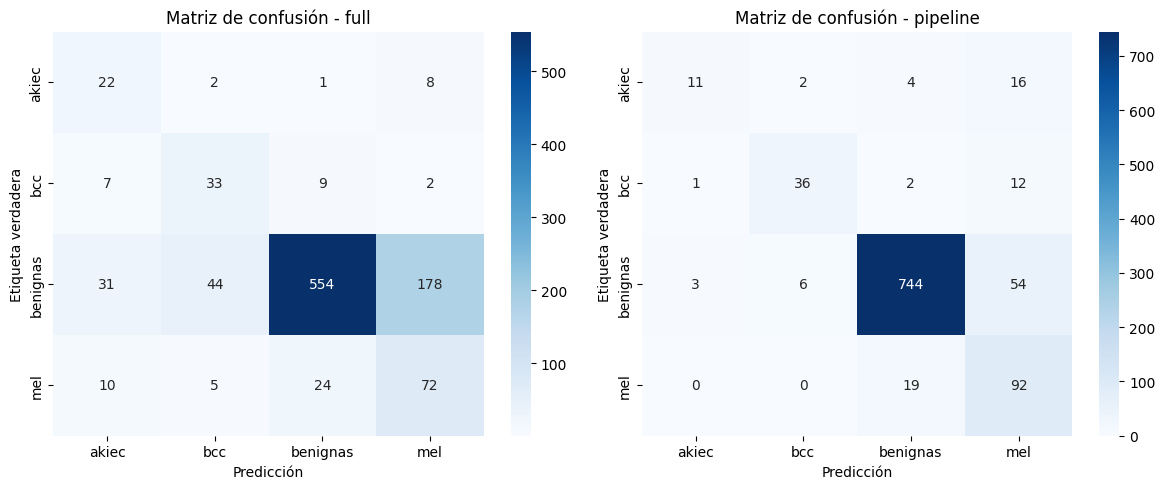

In [18]:
modelos = [
    ("models/full/vgg16Full_finetuned_11_29_17_11.keras",vgg16_preprocess, "full"),
    (("models/classifier/vgg16_finetuned_11_25_11_17.keras",
      "models/malignClassifier/knn_model_finetunedEncoder_11_29_h11_35.pkl",
      "models/encoder/encoder_finetuned_11_26_h15_34.keras"),vgg16_preprocess, "pipeline"),
]
comparar_modelos(modelos, "data/full/test",(224,224))

## Visaulize embeddings

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import math

def visualize_embeddings(model, val_generator, class_names, method="tsne", dims=3):
    """
    Visualiza embeddings en 2D o 3D usando t-SNE o PCA.
    dims: número de dimensiones (2 o 3)
    """

    assert dims in [2, 3], "dims debe ser 2 o 3"

    # 1. Calcular pasos reales (ceil para no perder imágenes)
    validation_steps = math.ceil(val_generator.samples / val_generator.batch_size)

    embs, labs = [], []
    for _ in range(validation_steps):
        images, labels = next(val_generator)
        e = model(images, training=False).numpy()
        embs.append(e)
        labs.append(labels)

    # 2. Concatenar embeddings y etiquetas
    X = np.concatenate(embs, axis=0)
    y = np.concatenate(labs, axis=0)

    # Convertir etiquetas a índices (one-hot, probabilidades o sparse)
    if y.ndim > 1:
        y = np.argmax(y, axis=1)
    else:
        y = y.astype(int)

    # 3. Reducir dimensionalidad
    if method == "tsne":
        perplexity = min(30, X.shape[0] - 1)
        reducer = TSNE(n_components=dims, perplexity=perplexity,
                       learning_rate=200, random_state=42)
    else:
        reducer = PCA(n_components=dims)

    X_reduced = reducer.fit_transform(X)

    # 4. Visualizar
    if dims == 3:
        fig = px.scatter_3d(
            x=X_reduced[:, 0],
            y=X_reduced[:, 1],
            z=X_reduced[:, 2],
            color=[class_names[int(i)] for i in y],
            title=f"Embeddings en {dims}D ({method.upper()})",
            opacity=0.7
        )
    else:  # dims == 2
        fig = px.scatter(
            x=X_reduced[:, 0],
            y=X_reduced[:, 1],
            color=[class_names[int(i)] for i in y],
            title=f"Embeddings en {dims}D ({method.upper()})",
            opacity=0.7
        )

    fig.show()


In [24]:
encoder = contrastive_encoder(input_shape=(128,128,3), embedding_dim=128)
encoder.load_weights("models/encoder/encoder_11_26_h14_27.keras")

In [26]:
test_generator = ImageDataGenerator(preprocessing_function=lambda x: x/255.).flow_from_directory(
        "data/malignas_classes/test",
        target_size=(128, 128),
        batch_size= 32,
        class_mode='categorical',
        shuffle=False
    )
class_names = list(test_generator.class_indices.keys())

Found 195 images belonging to 3 classes.


In [27]:
visualize_embeddings(encoder, test_generator, class_names, dims=3)

In [28]:
visualize_embeddings(encoder, test_generator, class_names, dims=2)